In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 322854, done.
remote: Counting objects: 100% (839/839), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 322854 (delta 696), reused 818 (delta 683), pack-reused 322015
Receiving objects: 100% (322854/322854), 656.80 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (296719/296719), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!pip install tensorflow object_detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

import sys
sys.path.append('/content/')

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler


In [ ]:
files_dir = '/content/drive/MyDrive/VisDroneTrain/'
test_dir = '/content/drive/MyDrive/VisDroneTest/'

In [ ]:
class VisDroneDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'pedestrian','people','bicycle', 
                        'car','van','truck','tricycle','awning-tricycle','bus','motor']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # dividing by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        
        with open(annot_file_path, 'r') as f:
            for line in f:
                box = [float(x) for x in line.strip().split(',')]
                labels.append(int(box[-1]))
                
                xmin, ymin, w, h = box[:4]
                xmax = xmin + w
                ymax = ymin + h
                
                xmin_corr = (xmin/img.shape[1])*self.width
                xmax_corr = (xmax/img.shape[1])*self.width
                ymin_corr = (ymin/img.shape[0])*self.height
                ymax_corr = (ymax/img.shape[0])*self.height
                
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)
  

In [ ]:
# check dataset
dataset = VisDroneDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  19 



In [ ]:
# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[1]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 77.9333, 168.0000, 117.3667, 208.2370],
        [126.0000, 131.4963, 154.4667, 150.9926],
        [110.1333, 143.5259, 140.7000, 164.2667],
        [ 92.1667, 157.6296, 130.6667, 176.2963],
        [140.2333, 122.7852, 157.9667, 136.8889],
        [ 10.2667,  76.3259,  46.6667, 144.7704],
        [  0.0000,  41.4815,  32.2000,  66.7852],
        [174.0667,  17.4222, 224.0000,  63.0519],
        [ 19.8333, 160.1185,  39.2000, 177.5407],
        [ 45.0333, 147.6741,  59.2667, 165.9259],
        [ 22.1667, 187.0815,  41.5333, 208.6519],
        [ 17.2667, 202.0148,  39.2000, 224.0000],
        [ 24.9667, 215.7037,  42.9333, 224.0000],
        [ 55.7667, 177.9556,  69.3000, 201.1852],
        [ 63.9333, 210.3111,  84.7000, 224.0000],
        [164.9667,  97.8963, 177.8000, 108.6815],
        [157.7333, 102.0444, 170.1000, 115.3185],
        [154.4667, 107.8519, 164.9667, 118.2222],
        [150.7333, 111.5852, 162.6333, 122.3704],
        [147.2333,  91.6

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    label_names = {0: '', 1: 'Truck', 2: 'Car'}
    for box, label in zip(target['boxes'], target['labels']):
      x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y), width, height,
                                linewidth=1, edgecolor='b', facecolor='none')
      a.add_patch(rect)
      label_text = label_names[label.item()]
      a.text(x, y, f"label={label_text}", color='r', fontsize=8)


    plt.show()

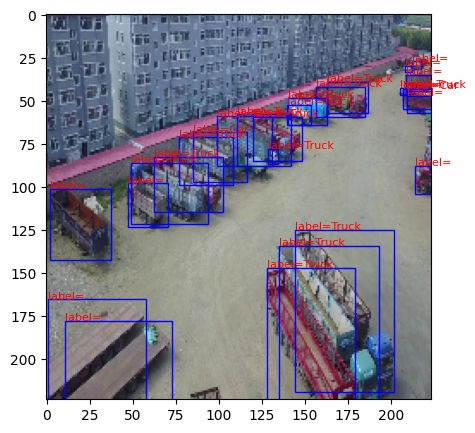

In [ ]:
# plotting the image with bboxes.
img, target = dataset[11]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = VisDroneDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = VisDroneDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# Define the hyperparameters
lr = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr,
                            momentum, weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size,
                                               gamma)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 56.1MB/s]


In [ ]:
# training for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/2]  eta: 0:07:46  lr: 0.005000  loss: 2.4671 (2.4671)  loss_classifier: 1.1656 (1.1656)  loss_box_reg: 0.7996 (0.7996)  loss_objectness: 0.3450 (0.3450)  loss_rpn_box_reg: 0.1570 (0.1570)  time: 233.2821  data: 4.5431
Epoch: [0]  [1/2]  eta: 0:02:56  lr: 0.005000  loss: 2.4671 (2.7386)  loss_classifier: 1.1385 (1.1521)  loss_box_reg: 0.7458 (0.7727)  loss_objectness: 0.3450 (0.5722)  loss_rpn_box_reg: 0.1570 (0.2417)  time: 176.3561  data: 2.2716
Epoch: [0] Total time: 0:05:52 (176.4086 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:19  model_time: 19.0432 (19.0432)  evaluator_time: 0.2270 (0.2270)  time: 19.7288  data: 0.4583
Test: Total time: 0:00:19 (19.9099 s / it)
Averaged stats: model_time: 19.0432 (19.0432)  evaluator_time: 0.2270 (0.2270)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxD

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):   
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
import numpy as np
import torch

# Assuming that `img` is a numpy array with image data
img_tensor = torch.from_numpy(img).to(device)


In [ ]:
model.eval()
with torch.no_grad():
    img_tensor = torch.from_numpy(img).to(device)
    img_tensor = img_tensor.permute(2, 0, 1)  # Permute the dimensions
    prediction = model([img_tensor])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels'])) 


predicted #boxes:  100
real #boxes:  57


In [ ]:
from torchvision.transforms import ConvertImageDtype, functional as F

img_tensor = F.to_tensor(img)  # convert to tensor
img_tensor = ConvertImageDtype(torch.uint8)(img_tensor)  # convert to uint8

EXPECTED OUTPUT


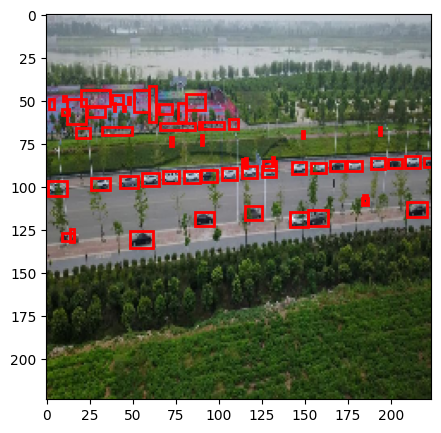

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), target)

MODEL OUTPUT


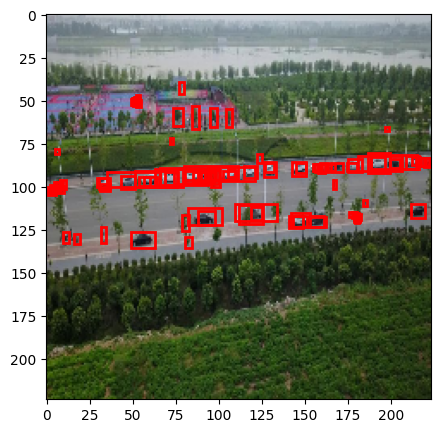

In [ ]:

print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), prediction)


NMS APPLIED MODEL OUTPUT


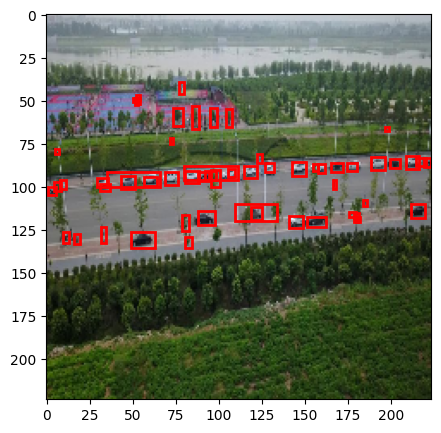

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), nms_prediction)

EXPECTED OUTPUT



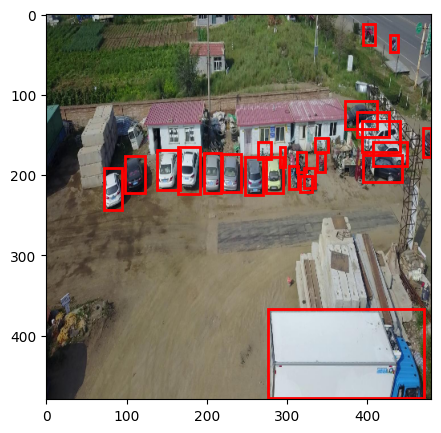

MODEL OUTPUT



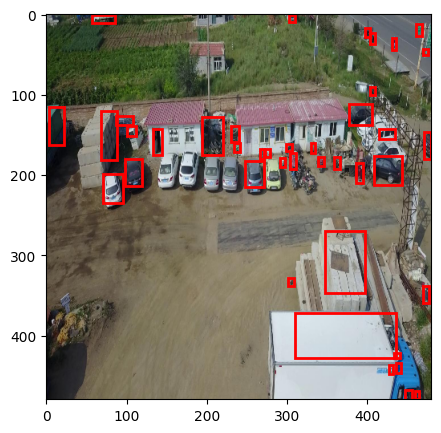

In [ ]:
test_dataset = VisDroneDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)